# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="cifar10.jpg" style="width:80%">

In [1]:
# when running in colab, un-comment this
# !wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

In [2]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)


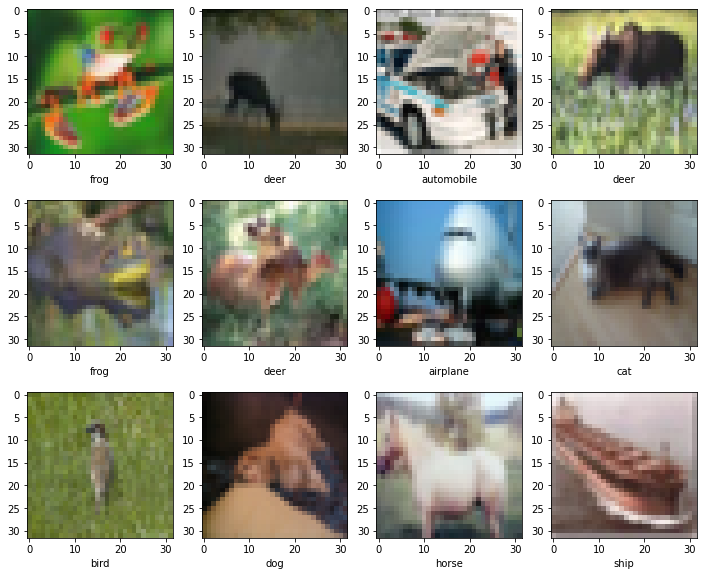

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [12]:
import torch, torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Let's start with a dense network for our baseline:

In [13]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [14]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [15]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.3282, grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [16]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [17]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [18]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in tqdm(range(num_epochs)):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

  1%|          | 1/100 [00:11<19:08, 11.60s/it]

Epoch 1 of 100 took 11.596s
  training loss (in-iteration): 	2.041981
  validation accuracy: 			33.29 %


  2%|▏         | 2/100 [00:22<17:59, 11.01s/it]

Epoch 2 of 100 took 10.601s
  training loss (in-iteration): 	1.862243
  validation accuracy: 			36.95 %


  3%|▎         | 3/100 [00:32<17:35, 10.89s/it]

Epoch 3 of 100 took 10.733s
  training loss (in-iteration): 	1.791713
  validation accuracy: 			38.57 %


  4%|▍         | 4/100 [00:43<17:13, 10.76s/it]

Epoch 4 of 100 took 10.569s
  training loss (in-iteration): 	1.738099
  validation accuracy: 			39.46 %


  5%|▌         | 5/100 [00:53<16:32, 10.45s/it]

Epoch 5 of 100 took 9.902s
  training loss (in-iteration): 	1.697028
  validation accuracy: 			40.39 %


  6%|▌         | 6/100 [01:05<17:02, 10.88s/it]

Epoch 6 of 100 took 11.718s
  training loss (in-iteration): 	1.665166
  validation accuracy: 			42.55 %


  7%|▋         | 7/100 [01:15<16:26, 10.60s/it]

Epoch 7 of 100 took 10.026s
  training loss (in-iteration): 	1.635410
  validation accuracy: 			43.15 %


  8%|▊         | 8/100 [01:25<16:14, 10.60s/it]

Epoch 8 of 100 took 10.581s
  training loss (in-iteration): 	1.613156
  validation accuracy: 			44.27 %


  9%|▉         | 9/100 [01:35<15:53, 10.48s/it]

Epoch 9 of 100 took 10.226s
  training loss (in-iteration): 	1.592531
  validation accuracy: 			44.22 %


 10%|█         | 10/100 [01:46<15:49, 10.54s/it]

Epoch 10 of 100 took 10.684s
  training loss (in-iteration): 	1.573251
  validation accuracy: 			43.97 %


 11%|█         | 11/100 [01:57<15:49, 10.67s/it]

Epoch 11 of 100 took 10.964s
  training loss (in-iteration): 	1.557958
  validation accuracy: 			45.13 %


 12%|█▏        | 12/100 [02:08<15:43, 10.73s/it]

Epoch 12 of 100 took 10.844s
  training loss (in-iteration): 	1.542611
  validation accuracy: 			45.59 %


 13%|█▎        | 13/100 [02:16<14:33, 10.04s/it]

Epoch 13 of 100 took 8.455s
  training loss (in-iteration): 	1.529598
  validation accuracy: 			45.22 %


 14%|█▍        | 14/100 [02:27<14:38, 10.21s/it]

Epoch 14 of 100 took 10.617s
  training loss (in-iteration): 	1.514777
  validation accuracy: 			45.77 %


 15%|█▌        | 15/100 [02:38<14:40, 10.36s/it]

Epoch 15 of 100 took 10.701s
  training loss (in-iteration): 	1.506094
  validation accuracy: 			46.14 %


 16%|█▌        | 16/100 [02:48<14:22, 10.27s/it]

Epoch 16 of 100 took 10.063s
  training loss (in-iteration): 	1.491942
  validation accuracy: 			47.20 %


 17%|█▋        | 17/100 [02:58<14:08, 10.23s/it]

Epoch 17 of 100 took 10.116s
  training loss (in-iteration): 	1.479679
  validation accuracy: 			46.97 %


 18%|█▊        | 18/100 [03:08<13:57, 10.21s/it]

Epoch 18 of 100 took 10.164s
  training loss (in-iteration): 	1.468803
  validation accuracy: 			45.73 %


 19%|█▉        | 19/100 [03:19<13:56, 10.33s/it]

Epoch 19 of 100 took 10.618s
  training loss (in-iteration): 	1.457957
  validation accuracy: 			46.74 %


 20%|██        | 20/100 [03:27<12:52,  9.65s/it]

Epoch 20 of 100 took 8.071s
  training loss (in-iteration): 	1.448353
  validation accuracy: 			46.40 %


 21%|██        | 21/100 [03:38<13:23, 10.17s/it]

Epoch 21 of 100 took 11.361s
  training loss (in-iteration): 	1.439578
  validation accuracy: 			47.67 %


 22%|██▏       | 22/100 [03:49<13:26, 10.34s/it]

Epoch 22 of 100 took 10.726s
  training loss (in-iteration): 	1.430585
  validation accuracy: 			46.68 %


 23%|██▎       | 23/100 [03:59<13:11, 10.28s/it]

Epoch 23 of 100 took 10.143s
  training loss (in-iteration): 	1.421866
  validation accuracy: 			48.07 %


 24%|██▍       | 24/100 [04:09<12:57, 10.23s/it]

Epoch 24 of 100 took 10.123s
  training loss (in-iteration): 	1.413071
  validation accuracy: 			47.50 %


 25%|██▌       | 25/100 [04:20<12:55, 10.35s/it]

Epoch 25 of 100 took 10.609s
  training loss (in-iteration): 	1.407137
  validation accuracy: 			47.99 %


 26%|██▌       | 26/100 [04:30<12:45, 10.35s/it]

Epoch 26 of 100 took 10.356s
  training loss (in-iteration): 	1.395454
  validation accuracy: 			48.98 %


 27%|██▋       | 27/100 [04:41<12:45, 10.48s/it]

Epoch 27 of 100 took 10.791s
  training loss (in-iteration): 	1.392453
  validation accuracy: 			48.94 %


 28%|██▊       | 28/100 [04:52<12:44, 10.61s/it]

Epoch 28 of 100 took 10.913s
  training loss (in-iteration): 	1.382652
  validation accuracy: 			48.91 %


 29%|██▉       | 29/100 [05:00<11:50, 10.01s/it]

Epoch 29 of 100 took 8.587s
  training loss (in-iteration): 	1.376802
  validation accuracy: 			49.62 %


 30%|███       | 30/100 [05:09<11:11,  9.60s/it]

Epoch 30 of 100 took 8.647s
  training loss (in-iteration): 	1.371492
  validation accuracy: 			48.62 %


 31%|███       | 31/100 [05:20<11:21,  9.88s/it]

Epoch 31 of 100 took 10.545s
  training loss (in-iteration): 	1.365139
  validation accuracy: 			49.70 %


 32%|███▏      | 32/100 [05:29<11:10,  9.86s/it]

Epoch 32 of 100 took 9.816s
  training loss (in-iteration): 	1.359793
  validation accuracy: 			47.82 %


 33%|███▎      | 33/100 [05:40<11:05,  9.93s/it]

Epoch 33 of 100 took 10.081s
  training loss (in-iteration): 	1.352568
  validation accuracy: 			49.90 %


 34%|███▍      | 34/100 [05:49<10:54,  9.91s/it]

Epoch 34 of 100 took 9.874s
  training loss (in-iteration): 	1.345723
  validation accuracy: 			50.01 %


 35%|███▌      | 35/100 [06:00<11:03, 10.21s/it]

Epoch 35 of 100 took 10.904s
  training loss (in-iteration): 	1.342651
  validation accuracy: 			49.73 %


 36%|███▌      | 36/100 [06:11<11:03, 10.37s/it]

Epoch 36 of 100 took 10.744s
  training loss (in-iteration): 	1.335098
  validation accuracy: 			49.65 %


 37%|███▋      | 37/100 [06:22<10:59, 10.47s/it]

Epoch 37 of 100 took 10.702s
  training loss (in-iteration): 	1.331698
  validation accuracy: 			48.43 %


 38%|███▊      | 38/100 [06:32<10:44, 10.39s/it]

Epoch 38 of 100 took 10.204s
  training loss (in-iteration): 	1.323796
  validation accuracy: 			49.08 %


 39%|███▉      | 39/100 [06:43<10:43, 10.55s/it]

Epoch 39 of 100 took 10.913s
  training loss (in-iteration): 	1.319519
  validation accuracy: 			48.80 %


 40%|████      | 40/100 [06:54<10:37, 10.63s/it]

Epoch 40 of 100 took 10.817s
  training loss (in-iteration): 	1.314326
  validation accuracy: 			49.82 %


 41%|████      | 41/100 [07:04<10:21, 10.54s/it]

Epoch 41 of 100 took 10.313s
  training loss (in-iteration): 	1.309419
  validation accuracy: 			48.52 %


 42%|████▏     | 42/100 [07:15<10:15, 10.61s/it]

Epoch 42 of 100 took 10.773s
  training loss (in-iteration): 	1.305123
  validation accuracy: 			48.37 %


 43%|████▎     | 43/100 [07:26<10:13, 10.77s/it]

Epoch 43 of 100 took 11.137s
  training loss (in-iteration): 	1.299710
  validation accuracy: 			48.11 %


 44%|████▍     | 44/100 [07:38<10:20, 11.08s/it]

Epoch 44 of 100 took 11.815s
  training loss (in-iteration): 	1.297947
  validation accuracy: 			49.80 %


 45%|████▌     | 45/100 [07:49<10:09, 11.08s/it]

Epoch 45 of 100 took 11.068s
  training loss (in-iteration): 	1.294276
  validation accuracy: 			49.80 %


 46%|████▌     | 46/100 [07:59<09:39, 10.73s/it]

Epoch 46 of 100 took 9.911s
  training loss (in-iteration): 	1.286671
  validation accuracy: 			50.15 %


 47%|████▋     | 47/100 [08:09<09:26, 10.68s/it]

Epoch 47 of 100 took 10.565s
  training loss (in-iteration): 	1.284283
  validation accuracy: 			48.65 %


 48%|████▊     | 48/100 [08:18<08:48, 10.17s/it]

Epoch 48 of 100 took 8.966s
  training loss (in-iteration): 	1.276605
  validation accuracy: 			50.27 %


 49%|████▉     | 49/100 [08:29<08:49, 10.39s/it]

Epoch 49 of 100 took 10.901s
  training loss (in-iteration): 	1.271319
  validation accuracy: 			50.24 %


 50%|█████     | 50/100 [08:41<09:03, 10.87s/it]

Epoch 50 of 100 took 11.990s
  training loss (in-iteration): 	1.272095
  validation accuracy: 			49.45 %


 51%|█████     | 51/100 [08:52<08:45, 10.72s/it]

Epoch 51 of 100 took 10.381s
  training loss (in-iteration): 	1.264785
  validation accuracy: 			48.26 %


 51%|█████     | 51/100 [09:00<08:39, 10.61s/it]


KeyboardInterrupt: 

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [19]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		48.63 %
We need more magic! Follow instructons below


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [74]:
device = 'cuda:1'
model = nn.Sequential()

model.add_module('conv_layer', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3))
model.add_module('conv_relu', nn.ReLU())
model.add_module('pooling', nn.MaxPool2d(2))
model.add_module('flatten', Flatten())
model.add_module('linear', nn.Linear(2250, 100))
model.add_module('linera_relu', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.1))
model.add_module('output', nn.Linear(100, 10))

model = model.to(device)

In [167]:
def compute_loss(X_batch, y_batch, device):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64).to(device)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [76]:
compute_loss(X_train[:5], y_train[:5], device)

tensor(2.3926, device='cuda:1', grad_fn=<MeanBackward0>)

In [78]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss = []
val_accuracy = []

In [79]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in tqdm(range(num_epochs)):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch, device)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
        y_pred = logits.max(1)[1].data.cpu().numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

  1%|          | 1/100 [00:01<02:33,  1.55s/it]

Epoch 1 of 100 took 1.552s
  training loss (in-iteration): 	1.690719
  validation accuracy: 			47.68 %


  2%|▏         | 2/100 [00:03<02:34,  1.57s/it]

Epoch 2 of 100 took 1.586s
  training loss (in-iteration): 	1.396563
  validation accuracy: 			53.31 %


  3%|▎         | 3/100 [00:04<02:32,  1.57s/it]

Epoch 3 of 100 took 1.574s
  training loss (in-iteration): 	1.308411
  validation accuracy: 			54.67 %


  4%|▍         | 4/100 [00:06<02:31,  1.58s/it]

Epoch 4 of 100 took 1.594s
  training loss (in-iteration): 	1.249284
  validation accuracy: 			56.30 %


  5%|▌         | 5/100 [00:07<02:30,  1.58s/it]

Epoch 5 of 100 took 1.576s
  training loss (in-iteration): 	1.195151
  validation accuracy: 			57.53 %


  6%|▌         | 6/100 [00:09<02:28,  1.57s/it]

Epoch 6 of 100 took 1.562s
  training loss (in-iteration): 	1.156884
  validation accuracy: 			58.21 %


  7%|▋         | 7/100 [00:11<02:26,  1.58s/it]

Epoch 7 of 100 took 1.583s
  training loss (in-iteration): 	1.119275
  validation accuracy: 			58.98 %


  8%|▊         | 8/100 [00:12<02:24,  1.57s/it]

Epoch 8 of 100 took 1.562s
  training loss (in-iteration): 	1.084054
  validation accuracy: 			58.91 %


  9%|▉         | 9/100 [00:14<02:22,  1.57s/it]

Epoch 9 of 100 took 1.559s
  training loss (in-iteration): 	1.052903
  validation accuracy: 			59.65 %


 10%|█         | 10/100 [00:15<02:21,  1.57s/it]

Epoch 10 of 100 took 1.580s
  training loss (in-iteration): 	1.027036
  validation accuracy: 			59.45 %


 11%|█         | 11/100 [00:17<02:19,  1.57s/it]

Epoch 11 of 100 took 1.571s
  training loss (in-iteration): 	1.007585
  validation accuracy: 			59.75 %


 12%|█▏        | 12/100 [00:18<02:18,  1.57s/it]

Epoch 12 of 100 took 1.559s
  training loss (in-iteration): 	0.975297
  validation accuracy: 			59.46 %


 13%|█▎        | 13/100 [00:20<02:16,  1.57s/it]

Epoch 13 of 100 took 1.560s
  training loss (in-iteration): 	0.959942
  validation accuracy: 			58.79 %


 14%|█▍        | 14/100 [00:22<02:14,  1.57s/it]

Epoch 14 of 100 took 1.570s
  training loss (in-iteration): 	0.933117
  validation accuracy: 			60.20 %


 15%|█▌        | 15/100 [00:23<02:13,  1.57s/it]

Epoch 15 of 100 took 1.574s
  training loss (in-iteration): 	0.916759
  validation accuracy: 			59.15 %


 16%|█▌        | 16/100 [00:25<02:11,  1.57s/it]

Epoch 16 of 100 took 1.565s
  training loss (in-iteration): 	0.892830
  validation accuracy: 			58.40 %


 17%|█▋        | 17/100 [00:26<02:10,  1.57s/it]

Epoch 17 of 100 took 1.561s
  training loss (in-iteration): 	0.875550
  validation accuracy: 			59.29 %


 18%|█▊        | 18/100 [00:28<02:08,  1.56s/it]

Epoch 18 of 100 took 1.549s
  training loss (in-iteration): 	0.854512
  validation accuracy: 			60.42 %


 19%|█▉        | 19/100 [00:29<02:06,  1.56s/it]

Epoch 19 of 100 took 1.560s
  training loss (in-iteration): 	0.837570
  validation accuracy: 			59.47 %


 20%|██        | 20/100 [00:31<02:05,  1.56s/it]

Epoch 20 of 100 took 1.567s
  training loss (in-iteration): 	0.818670
  validation accuracy: 			60.01 %


 21%|██        | 21/100 [00:32<02:03,  1.57s/it]

Epoch 21 of 100 took 1.576s
  training loss (in-iteration): 	0.802697
  validation accuracy: 			59.85 %


 22%|██▏       | 22/100 [00:34<02:02,  1.56s/it]

Epoch 22 of 100 took 1.556s
  training loss (in-iteration): 	0.782994
  validation accuracy: 			60.43 %


 23%|██▎       | 23/100 [00:36<02:00,  1.56s/it]

Epoch 23 of 100 took 1.564s
  training loss (in-iteration): 	0.770435
  validation accuracy: 			60.12 %


 24%|██▍       | 24/100 [00:37<01:58,  1.56s/it]

Epoch 24 of 100 took 1.559s
  training loss (in-iteration): 	0.760229
  validation accuracy: 			59.90 %


 25%|██▌       | 25/100 [00:39<01:57,  1.56s/it]

Epoch 25 of 100 took 1.567s
  training loss (in-iteration): 	0.739577
  validation accuracy: 			59.13 %


 26%|██▌       | 26/100 [00:40<01:56,  1.57s/it]

Epoch 26 of 100 took 1.577s
  training loss (in-iteration): 	0.730881
  validation accuracy: 			60.03 %


 27%|██▋       | 27/100 [00:42<01:54,  1.57s/it]

Epoch 27 of 100 took 1.575s
  training loss (in-iteration): 	0.714578
  validation accuracy: 			60.21 %


 28%|██▊       | 28/100 [00:43<01:53,  1.57s/it]

Epoch 28 of 100 took 1.568s
  training loss (in-iteration): 	0.693591
  validation accuracy: 			59.30 %


 29%|██▉       | 29/100 [00:45<01:51,  1.57s/it]

Epoch 29 of 100 took 1.574s
  training loss (in-iteration): 	0.686492
  validation accuracy: 			60.21 %


 30%|███       | 30/100 [00:47<01:49,  1.57s/it]

Epoch 30 of 100 took 1.568s
  training loss (in-iteration): 	0.671105
  validation accuracy: 			59.65 %


 31%|███       | 31/100 [00:48<01:48,  1.57s/it]

Epoch 31 of 100 took 1.562s
  training loss (in-iteration): 	0.659874
  validation accuracy: 			59.97 %


 32%|███▏      | 32/100 [00:50<01:46,  1.57s/it]

Epoch 32 of 100 took 1.571s
  training loss (in-iteration): 	0.642976
  validation accuracy: 			59.44 %


 33%|███▎      | 33/100 [00:51<01:44,  1.57s/it]

Epoch 33 of 100 took 1.558s
  training loss (in-iteration): 	0.631052
  validation accuracy: 			59.46 %


 34%|███▍      | 34/100 [00:53<01:44,  1.58s/it]

Epoch 34 of 100 took 1.601s
  training loss (in-iteration): 	0.622343
  validation accuracy: 			59.39 %


 35%|███▌      | 35/100 [00:54<01:42,  1.57s/it]

Epoch 35 of 100 took 1.553s
  training loss (in-iteration): 	0.610744
  validation accuracy: 			59.92 %


 36%|███▌      | 36/100 [00:56<01:40,  1.56s/it]

Epoch 36 of 100 took 1.546s
  training loss (in-iteration): 	0.596951
  validation accuracy: 			59.30 %


 37%|███▋      | 37/100 [00:58<01:38,  1.56s/it]

Epoch 37 of 100 took 1.565s
  training loss (in-iteration): 	0.591575
  validation accuracy: 			59.72 %


 38%|███▊      | 38/100 [00:59<01:36,  1.56s/it]

Epoch 38 of 100 took 1.550s
  training loss (in-iteration): 	0.574899
  validation accuracy: 			59.60 %


 39%|███▉      | 39/100 [01:01<01:35,  1.56s/it]

Epoch 39 of 100 took 1.559s
  training loss (in-iteration): 	0.564272
  validation accuracy: 			59.00 %


 40%|████      | 40/100 [01:02<01:33,  1.56s/it]

Epoch 40 of 100 took 1.556s
  training loss (in-iteration): 	0.560552
  validation accuracy: 			59.18 %


 41%|████      | 41/100 [01:04<01:31,  1.56s/it]

Epoch 41 of 100 took 1.552s
  training loss (in-iteration): 	0.550673
  validation accuracy: 			58.82 %


 42%|████▏     | 42/100 [01:05<01:30,  1.56s/it]

Epoch 42 of 100 took 1.558s
  training loss (in-iteration): 	0.542516
  validation accuracy: 			58.95 %


 43%|████▎     | 43/100 [01:07<01:28,  1.56s/it]

Epoch 43 of 100 took 1.556s
  training loss (in-iteration): 	0.534167
  validation accuracy: 			58.41 %


 44%|████▍     | 44/100 [01:08<01:27,  1.56s/it]

Epoch 44 of 100 took 1.560s
  training loss (in-iteration): 	0.519268
  validation accuracy: 			57.82 %


 45%|████▌     | 45/100 [01:10<01:25,  1.56s/it]

Epoch 45 of 100 took 1.558s
  training loss (in-iteration): 	0.510798
  validation accuracy: 			57.72 %


 46%|████▌     | 46/100 [01:12<01:24,  1.56s/it]

Epoch 46 of 100 took 1.549s
  training loss (in-iteration): 	0.502072
  validation accuracy: 			58.54 %


 47%|████▋     | 47/100 [01:13<01:22,  1.56s/it]

Epoch 47 of 100 took 1.551s
  training loss (in-iteration): 	0.494952
  validation accuracy: 			58.74 %


 48%|████▊     | 48/100 [01:15<01:20,  1.55s/it]

Epoch 48 of 100 took 1.550s
  training loss (in-iteration): 	0.482822
  validation accuracy: 			57.96 %


 49%|████▉     | 49/100 [01:16<01:19,  1.56s/it]

Epoch 49 of 100 took 1.561s
  training loss (in-iteration): 	0.479582
  validation accuracy: 			57.96 %


 50%|█████     | 50/100 [01:18<01:18,  1.56s/it]

Epoch 50 of 100 took 1.580s
  training loss (in-iteration): 	0.476774
  validation accuracy: 			57.84 %


 51%|█████     | 51/100 [01:19<01:16,  1.57s/it]

Epoch 51 of 100 took 1.577s
  training loss (in-iteration): 	0.470918
  validation accuracy: 			56.74 %


 52%|█████▏    | 52/100 [01:21<01:15,  1.57s/it]

Epoch 52 of 100 took 1.581s
  training loss (in-iteration): 	0.458668
  validation accuracy: 			57.77 %


 53%|█████▎    | 53/100 [01:23<01:14,  1.57s/it]

Epoch 53 of 100 took 1.579s
  training loss (in-iteration): 	0.457085
  validation accuracy: 			58.38 %


 54%|█████▍    | 54/100 [01:24<01:12,  1.58s/it]

Epoch 54 of 100 took 1.574s
  training loss (in-iteration): 	0.442503
  validation accuracy: 			57.87 %


 55%|█████▌    | 55/100 [01:26<01:11,  1.58s/it]

Epoch 55 of 100 took 1.597s
  training loss (in-iteration): 	0.441310
  validation accuracy: 			57.40 %


 56%|█████▌    | 56/100 [01:27<01:09,  1.58s/it]

Epoch 56 of 100 took 1.578s
  training loss (in-iteration): 	0.431071
  validation accuracy: 			58.27 %


 57%|█████▋    | 57/100 [01:29<01:07,  1.58s/it]

Epoch 57 of 100 took 1.567s
  training loss (in-iteration): 	0.425486
  validation accuracy: 			57.51 %


 58%|█████▊    | 58/100 [01:30<01:06,  1.58s/it]

Epoch 58 of 100 took 1.598s
  training loss (in-iteration): 	0.417900
  validation accuracy: 			57.12 %


 59%|█████▉    | 59/100 [01:32<01:04,  1.58s/it]

Epoch 59 of 100 took 1.585s
  training loss (in-iteration): 	0.421491
  validation accuracy: 			56.96 %


 60%|██████    | 60/100 [01:34<01:03,  1.58s/it]

Epoch 60 of 100 took 1.577s
  training loss (in-iteration): 	0.409761
  validation accuracy: 			56.98 %


 61%|██████    | 61/100 [01:35<01:01,  1.58s/it]

Epoch 61 of 100 took 1.558s
  training loss (in-iteration): 	0.414154
  validation accuracy: 			57.55 %


 62%|██████▏   | 62/100 [01:37<00:59,  1.57s/it]

Epoch 62 of 100 took 1.544s
  training loss (in-iteration): 	0.402118
  validation accuracy: 			57.59 %


 63%|██████▎   | 63/100 [01:38<00:57,  1.56s/it]

Epoch 63 of 100 took 1.555s
  training loss (in-iteration): 	0.396987
  validation accuracy: 			57.38 %


 64%|██████▍   | 64/100 [01:40<00:56,  1.56s/it]

Epoch 64 of 100 took 1.551s
  training loss (in-iteration): 	0.395297
  validation accuracy: 			57.78 %


 65%|██████▌   | 65/100 [01:41<00:54,  1.56s/it]

Epoch 65 of 100 took 1.561s
  training loss (in-iteration): 	0.387371
  validation accuracy: 			57.38 %


 66%|██████▌   | 66/100 [01:43<00:52,  1.56s/it]

Epoch 66 of 100 took 1.548s
  training loss (in-iteration): 	0.384736
  validation accuracy: 			57.22 %


 67%|██████▋   | 67/100 [01:45<00:51,  1.56s/it]

Epoch 67 of 100 took 1.562s
  training loss (in-iteration): 	0.381633
  validation accuracy: 			57.44 %


 68%|██████▊   | 68/100 [01:46<00:49,  1.56s/it]

Epoch 68 of 100 took 1.546s
  training loss (in-iteration): 	0.380994
  validation accuracy: 			56.64 %


 69%|██████▉   | 69/100 [01:48<00:48,  1.56s/it]

Epoch 69 of 100 took 1.558s
  training loss (in-iteration): 	0.364753
  validation accuracy: 			56.70 %


 70%|███████   | 70/100 [01:49<00:46,  1.56s/it]

Epoch 70 of 100 took 1.555s
  training loss (in-iteration): 	0.369028
  validation accuracy: 			56.97 %


 71%|███████   | 71/100 [01:51<00:45,  1.55s/it]

Epoch 71 of 100 took 1.547s
  training loss (in-iteration): 	0.358812
  validation accuracy: 			56.88 %


 72%|███████▏  | 72/100 [01:52<00:43,  1.55s/it]

Epoch 72 of 100 took 1.552s
  training loss (in-iteration): 	0.362502
  validation accuracy: 			56.83 %


 73%|███████▎  | 73/100 [01:54<00:41,  1.55s/it]

Epoch 73 of 100 took 1.553s
  training loss (in-iteration): 	0.356041
  validation accuracy: 			56.73 %


 74%|███████▍  | 74/100 [01:55<00:40,  1.56s/it]

Epoch 74 of 100 took 1.570s
  training loss (in-iteration): 	0.344574
  validation accuracy: 			56.37 %


 75%|███████▌  | 75/100 [01:57<00:39,  1.56s/it]

Epoch 75 of 100 took 1.574s
  training loss (in-iteration): 	0.348764
  validation accuracy: 			56.79 %


 76%|███████▌  | 76/100 [01:59<00:37,  1.57s/it]

Epoch 76 of 100 took 1.578s
  training loss (in-iteration): 	0.341078
  validation accuracy: 			57.18 %


 77%|███████▋  | 77/100 [02:00<00:36,  1.57s/it]

Epoch 77 of 100 took 1.569s
  training loss (in-iteration): 	0.335169
  validation accuracy: 			56.34 %


 78%|███████▊  | 78/100 [02:02<00:34,  1.57s/it]

Epoch 78 of 100 took 1.574s
  training loss (in-iteration): 	0.331947
  validation accuracy: 			56.60 %


 79%|███████▉  | 79/100 [02:03<00:32,  1.57s/it]

Epoch 79 of 100 took 1.570s
  training loss (in-iteration): 	0.334049
  validation accuracy: 			56.32 %


 80%|████████  | 80/100 [02:05<00:31,  1.57s/it]

Epoch 80 of 100 took 1.563s
  training loss (in-iteration): 	0.327696
  validation accuracy: 			56.49 %


 81%|████████  | 81/100 [02:06<00:29,  1.57s/it]

Epoch 81 of 100 took 1.568s
  training loss (in-iteration): 	0.328076
  validation accuracy: 			56.54 %


 82%|████████▏ | 82/100 [02:08<00:28,  1.57s/it]

Epoch 82 of 100 took 1.566s
  training loss (in-iteration): 	0.327732
  validation accuracy: 			56.69 %


 83%|████████▎ | 83/100 [02:10<00:26,  1.56s/it]

Epoch 83 of 100 took 1.554s
  training loss (in-iteration): 	0.318923
  validation accuracy: 			56.63 %


 84%|████████▍ | 84/100 [02:11<00:25,  1.56s/it]

Epoch 84 of 100 took 1.563s
  training loss (in-iteration): 	0.318768
  validation accuracy: 			55.77 %


 85%|████████▌ | 85/100 [02:13<00:23,  1.57s/it]

Epoch 85 of 100 took 1.571s
  training loss (in-iteration): 	0.325356
  validation accuracy: 			56.45 %


 86%|████████▌ | 86/100 [02:14<00:22,  1.58s/it]

Epoch 86 of 100 took 1.596s
  training loss (in-iteration): 	0.311929
  validation accuracy: 			56.80 %


 87%|████████▋ | 87/100 [02:16<00:20,  1.58s/it]

Epoch 87 of 100 took 1.588s
  training loss (in-iteration): 	0.316076
  validation accuracy: 			56.20 %


 88%|████████▊ | 88/100 [02:17<00:19,  1.59s/it]

Epoch 88 of 100 took 1.602s
  training loss (in-iteration): 	0.312687
  validation accuracy: 			56.29 %


 89%|████████▉ | 89/100 [02:19<00:17,  1.58s/it]

Epoch 89 of 100 took 1.561s
  training loss (in-iteration): 	0.305456
  validation accuracy: 			56.16 %


 90%|█████████ | 90/100 [02:21<00:15,  1.57s/it]

Epoch 90 of 100 took 1.558s
  training loss (in-iteration): 	0.301785
  validation accuracy: 			56.13 %


 91%|█████████ | 91/100 [02:22<00:14,  1.57s/it]

Epoch 91 of 100 took 1.546s
  training loss (in-iteration): 	0.307281
  validation accuracy: 			56.19 %


 92%|█████████▏| 92/100 [02:24<00:12,  1.57s/it]

Epoch 92 of 100 took 1.571s
  training loss (in-iteration): 	0.303209
  validation accuracy: 			56.38 %


 93%|█████████▎| 93/100 [02:25<00:11,  1.58s/it]

Epoch 93 of 100 took 1.598s
  training loss (in-iteration): 	0.292704
  validation accuracy: 			55.98 %


 94%|█████████▍| 94/100 [02:27<00:09,  1.58s/it]

Epoch 94 of 100 took 1.575s
  training loss (in-iteration): 	0.289901
  validation accuracy: 			56.01 %


 95%|█████████▌| 95/100 [02:28<00:07,  1.58s/it]

Epoch 95 of 100 took 1.574s
  training loss (in-iteration): 	0.290886
  validation accuracy: 			55.81 %


 96%|█████████▌| 96/100 [02:30<00:06,  1.58s/it]

Epoch 96 of 100 took 1.573s
  training loss (in-iteration): 	0.285001
  validation accuracy: 			56.40 %


 97%|█████████▋| 97/100 [02:32<00:04,  1.58s/it]

Epoch 97 of 100 took 1.577s
  training loss (in-iteration): 	0.291989
  validation accuracy: 			56.66 %


 98%|█████████▊| 98/100 [02:33<00:03,  1.57s/it]

Epoch 98 of 100 took 1.565s
  training loss (in-iteration): 	0.285867
  validation accuracy: 			56.13 %


 99%|█████████▉| 99/100 [02:35<00:01,  1.57s/it]

Epoch 99 of 100 took 1.568s
  training loss (in-iteration): 	0.279036
  validation accuracy: 			55.81 %


100%|██████████| 100/100 [02:36<00:00,  1.57s/it]

Epoch 100 of 100 took 1.570s
  training loss (in-iteration): 	0.280067
  validation accuracy: 			55.52 %


In [80]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
    y_pred = logits.max(1)[1].data.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		55.30 %
Achievement unlocked: 60lvl Warlock!


```

```

```

```

```

```

```

```

```

```

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [168]:
device = 'cuda:1'
model = nn.Sequential()

model.add_module('conv_layer', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3))
model.add_module('batchnorm', nn.BatchNorm2d(10))
model.add_module('conv_relu', nn.ReLU())
model.add_module('pooling', nn.MaxPool2d(2))
model.add_module('flatten', Flatten())
model.add_module('linear', nn.Linear(2250, 100))
model.add_module('batchnorm_linear', nn.BatchNorm1d(100))
model.add_module('linera_relu', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.1))
model.add_module('output', nn.Linear(100, 10))

model = model.to(device)

In [169]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss = []
val_accuracy = []

In [170]:
import time
num_epochs = 20 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in tqdm(range(num_epochs)):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch, device)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
        y_pred = logits.max(1)[1].data.cpu().numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

  5%|▌         | 1/20 [00:02<00:39,  2.07s/it]

Epoch 1 of 20 took 2.066s
  training loss (in-iteration): 	1.412696
  validation accuracy: 			55.85 %


 10%|█         | 2/20 [00:04<00:36,  2.05s/it]

Epoch 2 of 20 took 2.036s
  training loss (in-iteration): 	1.131318
  validation accuracy: 			58.78 %


 15%|█▌        | 3/20 [00:06<00:34,  2.05s/it]

Epoch 3 of 20 took 2.048s
  training loss (in-iteration): 	1.007606
  validation accuracy: 			60.28 %


 20%|██        | 4/20 [00:08<00:32,  2.05s/it]

Epoch 4 of 20 took 2.052s
  training loss (in-iteration): 	0.918610
  validation accuracy: 			61.39 %


 25%|██▌       | 5/20 [00:10<00:30,  2.05s/it]

Epoch 5 of 20 took 2.051s
  training loss (in-iteration): 	0.842027
  validation accuracy: 			62.05 %


 30%|███       | 6/20 [00:12<00:28,  2.05s/it]

Epoch 6 of 20 took 2.054s
  training loss (in-iteration): 	0.778826
  validation accuracy: 			62.37 %


 35%|███▌      | 7/20 [00:14<00:26,  2.05s/it]

Epoch 7 of 20 took 2.050s
  training loss (in-iteration): 	0.714194
  validation accuracy: 			63.73 %


 40%|████      | 8/20 [00:16<00:24,  2.06s/it]

Epoch 8 of 20 took 2.058s
  training loss (in-iteration): 	0.664510
  validation accuracy: 			63.20 %


 45%|████▌     | 9/20 [00:18<00:22,  2.07s/it]

Epoch 9 of 20 took 2.094s
  training loss (in-iteration): 	0.615987
  validation accuracy: 			63.21 %


 50%|█████     | 10/20 [00:20<00:20,  2.07s/it]

Epoch 10 of 20 took 2.073s
  training loss (in-iteration): 	0.571002
  validation accuracy: 			63.22 %


 55%|█████▌    | 11/20 [00:22<00:18,  2.07s/it]

Epoch 11 of 20 took 2.054s
  training loss (in-iteration): 	0.531670
  validation accuracy: 			62.34 %


 60%|██████    | 12/20 [00:24<00:16,  2.07s/it]

Epoch 12 of 20 took 2.070s
  training loss (in-iteration): 	0.492554
  validation accuracy: 			61.74 %


 65%|██████▌   | 13/20 [00:26<00:14,  2.06s/it]

Epoch 13 of 20 took 2.057s
  training loss (in-iteration): 	0.463235
  validation accuracy: 			61.98 %


 70%|███████   | 14/20 [00:28<00:12,  2.06s/it]

Epoch 14 of 20 took 2.054s
  training loss (in-iteration): 	0.437795
  validation accuracy: 			62.08 %


 75%|███████▌  | 15/20 [00:30<00:10,  2.06s/it]

Epoch 15 of 20 took 2.059s
  training loss (in-iteration): 	0.421208
  validation accuracy: 			62.40 %


 80%|████████  | 16/20 [00:32<00:08,  2.06s/it]

Epoch 16 of 20 took 2.040s
  training loss (in-iteration): 	0.383092
  validation accuracy: 			60.24 %


 85%|████████▌ | 17/20 [00:34<00:06,  2.05s/it]

Epoch 17 of 20 took 2.046s
  training loss (in-iteration): 	0.367816
  validation accuracy: 			61.73 %


 90%|█████████ | 18/20 [00:37<00:04,  2.06s/it]

Epoch 18 of 20 took 2.070s
  training loss (in-iteration): 	0.354310
  validation accuracy: 			62.47 %


 95%|█████████▌| 19/20 [00:39<00:02,  2.06s/it]

Epoch 19 of 20 took 2.055s
  training loss (in-iteration): 	0.330747
  validation accuracy: 			61.34 %


100%|██████████| 20/20 [00:41<00:00,  2.06s/it]

Epoch 20 of 20 took 2.060s
  training loss (in-iteration): 	0.319327
  validation accuracy: 			61.83 %


In [88]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
    y_pred = logits.max(1)[1].data.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		61.30 %
Achievement unlocked: 70lvl Warlock!



```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [313]:
device = 'cuda:1'
model = nn.Sequential()

model.add_module('conv_layer_1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3))
model.add_module('batchnorm_1', nn.BatchNorm2d(10))
model.add_module('conv_relu', nn.ReLU())
model.add_module('pooling_11', nn.MaxPool2d(2))

model.add_module('conv_layer_2', nn.Conv2d(in_channels=10, out_channels=12, kernel_size=3))
model.add_module('batchnorm_2', nn.BatchNorm2d(12))
model.add_module('conv_relu', nn.ReLU())
model.add_module('pooling_2', nn.MaxPool2d(2))

model.add_module('flatten', Flatten())
model.add_module('linear', nn.Linear(432, 256))
model.add_module('batchnorm_linear', nn.BatchNorm1d(256))
model.add_module('linera_relu', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.2))
model.add_module('output', nn.Linear(256, 10))
model = model.to(device)

In [314]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss = []
val_accuracy = []

In [315]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [316]:
from torchvision.datasets import CIFAR10
train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_batch_gen = torch.utils.data.DataLoader(train_loader, 
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=8)

In [317]:
num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (x_batch, y_batch) in train_batch_gen:
        #print('X:', type(x_batch), x_batch.shape)
        #print('y:', type(y_batch), y_batch.shape)
        
        #for i, img in enumerate(x_batch.numpy()[:8]):
        #    plt.subplot(2, 4, i+1)
        #    plt.imshow(img.transpose([1,2,0]) * stds + means )
            
        loss = compute_loss(x_batch, y_batch, device)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
        #raise NotImplementedError("Plese use this code in your training loop")
    
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))

  1%|          | 1/100 [00:06<10:42,  6.49s/it]

Epoch 1 of 100 took 6.483s
  training loss (in-iteration): 	1.549704


  2%|▏         | 2/100 [00:13<10:40,  6.53s/it]

Epoch 2 of 100 took 6.567s
  training loss (in-iteration): 	1.457255


  3%|▎         | 3/100 [00:19<10:38,  6.58s/it]

Epoch 3 of 100 took 6.633s
  training loss (in-iteration): 	1.402284


  4%|▍         | 4/100 [00:26<10:38,  6.65s/it]

Epoch 4 of 100 took 6.749s
  training loss (in-iteration): 	1.364118


  5%|▌         | 5/100 [00:33<10:34,  6.68s/it]

Epoch 5 of 100 took 6.737s
  training loss (in-iteration): 	1.326310


  6%|▌         | 6/100 [00:39<10:23,  6.63s/it]

Epoch 6 of 100 took 6.539s
  training loss (in-iteration): 	1.318158


  7%|▋         | 7/100 [00:46<10:10,  6.56s/it]

Epoch 7 of 100 took 6.412s
  training loss (in-iteration): 	1.283419


  8%|▊         | 8/100 [00:52<10:11,  6.64s/it]

Epoch 8 of 100 took 6.810s
  training loss (in-iteration): 	1.285093


  9%|▉         | 9/100 [00:59<10:04,  6.64s/it]

Epoch 9 of 100 took 6.638s
  training loss (in-iteration): 	1.269633


 10%|█         | 10/100 [01:06<09:58,  6.65s/it]

Epoch 10 of 100 took 6.678s
  training loss (in-iteration): 	1.254575


 11%|█         | 11/100 [01:12<09:51,  6.65s/it]

Epoch 11 of 100 took 6.635s
  training loss (in-iteration): 	1.244649


 12%|█▏        | 12/100 [01:19<09:48,  6.69s/it]

Epoch 12 of 100 took 6.793s
  training loss (in-iteration): 	1.238031


 13%|█▎        | 13/100 [01:26<09:42,  6.70s/it]

Epoch 13 of 100 took 6.706s
  training loss (in-iteration): 	1.230138


 14%|█▍        | 14/100 [01:33<09:35,  6.69s/it]

Epoch 14 of 100 took 6.679s
  training loss (in-iteration): 	1.226136


 15%|█▌        | 15/100 [01:39<09:30,  6.72s/it]

Epoch 15 of 100 took 6.766s
  training loss (in-iteration): 	1.221094


 16%|█▌        | 16/100 [01:46<09:19,  6.66s/it]

Epoch 16 of 100 took 6.540s
  training loss (in-iteration): 	1.207541


 17%|█▋        | 17/100 [01:53<09:15,  6.69s/it]

Epoch 17 of 100 took 6.752s
  training loss (in-iteration): 	1.204304


Exception ignored in: Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7efc1a57f160>>
<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7efc1a57f160>>Traceback (most recent call last):

  File "/home/kozunov/courses/dvag/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7efc1a57f160>>  File "/home/kozunov/courses/dvag/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
self._shutdown_workers()

      File "/home/kozunov/courses/dvag/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
self._shutdown_workers()
E

Epoch 18 of 100 took 7.146s
  training loss (in-iteration): 	1.194286


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7efc1a57f160>>
Exception ignored in: Traceback (most recent call last):
  File "/home/kozunov/courses/dvag/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7efc1a57f160>>    
self._shutdown_workers()
  File "/home/kozunov/courses/dvag/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/usr/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
Traceback (most recent call last):
<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7efc1a57f160>>    
assert self._parent_pid == os.getpid(), 'can only

Epoch 19 of 100 took 6.990s
  training loss (in-iteration): 	1.196706


Exception ignored in: Exception ignored in: Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7efc1a57f160>><bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7efc1a57f160>><bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7efc1a57f160>>

Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):

  File "/home/kozunov/courses/dvag/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7efc1a57f160>>Traceback (most recent call last):
  File "/home/kozunov/courses/dvag/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in 

Epoch 20 of 100 took 7.053s
  training loss (in-iteration): 	1.181030


Exception ignored in: Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7efc1a57f160>><bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7efc1a57f160>>
Exception ignored in: Traceback (most recent call last):
<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7efc1a57f160>>
  File "/home/kozunov/courses/dvag/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__

Traceback (most recent call last):
Traceback (most recent call last):
      File "/home/kozunov/courses/dvag/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
self._shutdown_workers()  File "/home/kozunov/courses/dvag/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    se

Epoch 21 of 100 took 7.269s
  training loss (in-iteration): 	1.184652


 22%|██▏       | 22/100 [02:28<08:55,  6.86s/it]

Epoch 22 of 100 took 6.455s
  training loss (in-iteration): 	1.187148


 23%|██▎       | 23/100 [02:34<08:43,  6.80s/it]

Epoch 23 of 100 took 6.644s
  training loss (in-iteration): 	1.163831


 24%|██▍       | 24/100 [02:41<08:29,  6.71s/it]

Epoch 24 of 100 took 6.500s
  training loss (in-iteration): 	1.174817


 25%|██▌       | 25/100 [02:47<08:15,  6.61s/it]

Epoch 25 of 100 took 6.364s
  training loss (in-iteration): 	1.174226


 26%|██▌       | 26/100 [02:54<08:05,  6.56s/it]

Epoch 26 of 100 took 6.469s
  training loss (in-iteration): 	1.157402


 27%|██▋       | 27/100 [03:00<07:55,  6.52s/it]

Epoch 27 of 100 took 6.402s
  training loss (in-iteration): 	1.152883


 28%|██▊       | 28/100 [03:06<07:47,  6.49s/it]

Epoch 28 of 100 took 6.439s
  training loss (in-iteration): 	1.165434


 29%|██▉       | 29/100 [03:13<07:42,  6.52s/it]

Epoch 29 of 100 took 6.566s
  training loss (in-iteration): 	1.162941


 30%|███       | 30/100 [03:20<07:40,  6.59s/it]

Epoch 30 of 100 took 6.745s
  training loss (in-iteration): 	1.159251


 31%|███       | 31/100 [03:26<07:35,  6.60s/it]

Epoch 31 of 100 took 6.625s
  training loss (in-iteration): 	1.143740


 32%|███▏      | 32/100 [03:33<07:27,  6.58s/it]

Epoch 32 of 100 took 6.536s
  training loss (in-iteration): 	1.152931


 33%|███▎      | 33/100 [03:39<07:18,  6.55s/it]

Epoch 33 of 100 took 6.468s
  training loss (in-iteration): 	1.150488


 34%|███▍      | 34/100 [03:46<07:09,  6.51s/it]

Epoch 34 of 100 took 6.437s
  training loss (in-iteration): 	1.145916


 35%|███▌      | 35/100 [03:52<07:02,  6.50s/it]

Epoch 35 of 100 took 6.456s
  training loss (in-iteration): 	1.138937


 36%|███▌      | 36/100 [03:59<06:59,  6.55s/it]

Epoch 36 of 100 took 6.669s
  training loss (in-iteration): 	1.127543


 37%|███▋      | 37/100 [04:05<06:51,  6.54s/it]

Epoch 37 of 100 took 6.508s
  training loss (in-iteration): 	1.138788


 38%|███▊      | 38/100 [04:12<06:43,  6.51s/it]

Epoch 38 of 100 took 6.429s
  training loss (in-iteration): 	1.146059


 39%|███▉      | 39/100 [04:18<06:37,  6.51s/it]

Epoch 39 of 100 took 6.521s
  training loss (in-iteration): 	1.139943


 40%|████      | 40/100 [04:25<06:29,  6.50s/it]

Epoch 40 of 100 took 6.462s
  training loss (in-iteration): 	1.137044


 41%|████      | 41/100 [04:31<06:25,  6.54s/it]

Epoch 41 of 100 took 6.626s
  training loss (in-iteration): 	1.133185


 42%|████▏     | 42/100 [04:38<06:20,  6.57s/it]

Epoch 42 of 100 took 6.638s
  training loss (in-iteration): 	1.129256


 43%|████▎     | 43/100 [04:45<06:13,  6.55s/it]

Epoch 43 of 100 took 6.497s
  training loss (in-iteration): 	1.132623


 44%|████▍     | 44/100 [04:51<06:05,  6.53s/it]

Epoch 44 of 100 took 6.478s
  training loss (in-iteration): 	1.116082


 45%|████▌     | 45/100 [04:58<05:57,  6.49s/it]

Epoch 45 of 100 took 6.418s
  training loss (in-iteration): 	1.124283


 46%|████▌     | 46/100 [05:04<05:50,  6.48s/it]

Epoch 46 of 100 took 6.454s
  training loss (in-iteration): 	1.119533


 47%|████▋     | 47/100 [05:11<05:44,  6.50s/it]

Epoch 47 of 100 took 6.533s
  training loss (in-iteration): 	1.123064


 48%|████▊     | 48/100 [05:17<05:37,  6.49s/it]

Epoch 48 of 100 took 6.469s
  training loss (in-iteration): 	1.116292


 49%|████▉     | 49/100 [05:24<05:32,  6.53s/it]

Epoch 49 of 100 took 6.607s
  training loss (in-iteration): 	1.106079


 50%|█████     | 50/100 [05:30<05:25,  6.50s/it]

Epoch 50 of 100 took 6.436s
  training loss (in-iteration): 	1.118703


 51%|█████     | 51/100 [05:36<05:17,  6.48s/it]

Epoch 51 of 100 took 6.428s
  training loss (in-iteration): 	1.121168


 52%|█████▏    | 52/100 [05:43<05:10,  6.46s/it]

Epoch 52 of 100 took 6.416s
  training loss (in-iteration): 	1.121631


 53%|█████▎    | 53/100 [05:49<05:03,  6.46s/it]

Epoch 53 of 100 took 6.471s
  training loss (in-iteration): 	1.116028


 54%|█████▍    | 54/100 [05:56<05:00,  6.54s/it]

Epoch 54 of 100 took 6.699s
  training loss (in-iteration): 	1.113340


 55%|█████▌    | 55/100 [06:03<04:54,  6.54s/it]

Epoch 55 of 100 took 6.558s
  training loss (in-iteration): 	1.105914


 56%|█████▌    | 56/100 [06:09<04:48,  6.56s/it]

Epoch 56 of 100 took 6.610s
  training loss (in-iteration): 	1.103107


 57%|█████▋    | 57/100 [06:16<04:42,  6.57s/it]

Epoch 57 of 100 took 6.585s
  training loss (in-iteration): 	1.104815


 58%|█████▊    | 58/100 [06:22<04:35,  6.55s/it]

Epoch 58 of 100 took 6.504s
  training loss (in-iteration): 	1.103210


 59%|█████▉    | 59/100 [06:29<04:28,  6.55s/it]

Epoch 59 of 100 took 6.530s
  training loss (in-iteration): 	1.101773


 60%|██████    | 60/100 [06:35<04:20,  6.52s/it]

Epoch 60 of 100 took 6.465s
  training loss (in-iteration): 	1.112744


 61%|██████    | 61/100 [06:42<04:15,  6.55s/it]

Epoch 61 of 100 took 6.614s
  training loss (in-iteration): 	1.112738


 62%|██████▏   | 62/100 [06:48<04:08,  6.54s/it]

Epoch 62 of 100 took 6.502s
  training loss (in-iteration): 	1.096660


 63%|██████▎   | 63/100 [06:55<04:01,  6.53s/it]

Epoch 63 of 100 took 6.514s
  training loss (in-iteration): 	1.115298


 64%|██████▍   | 64/100 [07:01<03:53,  6.49s/it]

Epoch 64 of 100 took 6.405s
  training loss (in-iteration): 	1.097029


 65%|██████▌   | 65/100 [07:08<03:49,  6.56s/it]

Epoch 65 of 100 took 6.701s
  training loss (in-iteration): 	1.101106


 66%|██████▌   | 66/100 [07:15<03:42,  6.55s/it]

Epoch 66 of 100 took 6.543s
  training loss (in-iteration): 	1.101854


 67%|██████▋   | 67/100 [07:21<03:37,  6.59s/it]

Epoch 67 of 100 took 6.664s
  training loss (in-iteration): 	1.106459


 68%|██████▊   | 68/100 [07:28<03:31,  6.61s/it]

Epoch 68 of 100 took 6.660s
  training loss (in-iteration): 	1.098476


 69%|██████▉   | 69/100 [07:35<03:27,  6.70s/it]

Epoch 69 of 100 took 6.895s
  training loss (in-iteration): 	1.097312


 70%|███████   | 70/100 [07:42<03:23,  6.77s/it]

Epoch 70 of 100 took 6.937s
  training loss (in-iteration): 	1.091859


 71%|███████   | 71/100 [07:48<03:15,  6.72s/it]

Epoch 71 of 100 took 6.619s
  training loss (in-iteration): 	1.095847


 72%|███████▏  | 72/100 [07:55<03:09,  6.77s/it]

Epoch 72 of 100 took 6.858s
  training loss (in-iteration): 	1.083408


 73%|███████▎  | 73/100 [08:02<03:00,  6.70s/it]

Epoch 73 of 100 took 6.543s
  training loss (in-iteration): 	1.093284


 74%|███████▍  | 74/100 [08:08<02:53,  6.66s/it]

Epoch 74 of 100 took 6.550s
  training loss (in-iteration): 	1.097948


 75%|███████▌  | 75/100 [08:15<02:47,  6.71s/it]

Epoch 75 of 100 took 6.839s
  training loss (in-iteration): 	1.090756


 76%|███████▌  | 76/100 [08:22<02:40,  6.69s/it]

Epoch 76 of 100 took 6.646s
  training loss (in-iteration): 	1.091416


 77%|███████▋  | 77/100 [08:28<02:33,  6.66s/it]

Epoch 77 of 100 took 6.580s
  training loss (in-iteration): 	1.092522


 78%|███████▊  | 78/100 [08:35<02:25,  6.63s/it]

Epoch 78 of 100 took 6.546s
  training loss (in-iteration): 	1.084149


 79%|███████▉  | 79/100 [08:42<02:19,  6.64s/it]

Epoch 79 of 100 took 6.666s
  training loss (in-iteration): 	1.080173


 80%|████████  | 80/100 [08:48<02:12,  6.64s/it]

Epoch 80 of 100 took 6.647s
  training loss (in-iteration): 	1.100213


 81%|████████  | 81/100 [08:55<02:05,  6.61s/it]

Epoch 81 of 100 took 6.520s
  training loss (in-iteration): 	1.082199


 82%|████████▏ | 82/100 [09:01<01:58,  6.57s/it]

Epoch 82 of 100 took 6.491s
  training loss (in-iteration): 	1.084359


 83%|████████▎ | 83/100 [09:08<01:51,  6.55s/it]

Epoch 83 of 100 took 6.503s
  training loss (in-iteration): 	1.080555


 84%|████████▍ | 84/100 [09:14<01:44,  6.56s/it]

Epoch 84 of 100 took 6.575s
  training loss (in-iteration): 	1.087249


 85%|████████▌ | 85/100 [09:21<01:38,  6.55s/it]

Epoch 85 of 100 took 6.517s
  training loss (in-iteration): 	1.088811


 86%|████████▌ | 86/100 [09:27<01:31,  6.56s/it]

Epoch 86 of 100 took 6.572s
  training loss (in-iteration): 	1.087620


 87%|████████▋ | 87/100 [09:34<01:26,  6.66s/it]

Epoch 87 of 100 took 6.890s
  training loss (in-iteration): 	1.082558


 88%|████████▊ | 88/100 [09:42<01:22,  6.84s/it]

Epoch 88 of 100 took 7.276s
  training loss (in-iteration): 	1.080313


 89%|████████▉ | 89/100 [09:49<01:18,  7.10s/it]

Epoch 89 of 100 took 7.703s
  training loss (in-iteration): 	1.087965


 90%|█████████ | 90/100 [09:56<01:10,  7.04s/it]

Epoch 90 of 100 took 6.887s
  training loss (in-iteration): 	1.082117


 91%|█████████ | 91/100 [10:03<01:02,  6.94s/it]

Epoch 91 of 100 took 6.724s
  training loss (in-iteration): 	1.084695


 92%|█████████▏| 92/100 [10:09<00:54,  6.80s/it]

Epoch 92 of 100 took 6.465s
  training loss (in-iteration): 	1.083350


 93%|█████████▎| 93/100 [10:16<00:47,  6.72s/it]

Epoch 93 of 100 took 6.527s
  training loss (in-iteration): 	1.073564


 94%|█████████▍| 94/100 [10:23<00:40,  6.69s/it]

Epoch 94 of 100 took 6.628s
  training loss (in-iteration): 	1.092344


 95%|█████████▌| 95/100 [10:29<00:33,  6.65s/it]

Epoch 95 of 100 took 6.534s
  training loss (in-iteration): 	1.068695


 96%|█████████▌| 96/100 [10:36<00:26,  6.60s/it]

Epoch 96 of 100 took 6.502s
  training loss (in-iteration): 	1.078583


 97%|█████████▋| 97/100 [10:42<00:19,  6.58s/it]

Epoch 97 of 100 took 6.533s
  training loss (in-iteration): 	1.071997


 98%|█████████▊| 98/100 [10:49<00:13,  6.56s/it]

Epoch 98 of 100 took 6.513s
  training loss (in-iteration): 	1.083393


 99%|█████████▉| 99/100 [10:55<00:06,  6.62s/it]

Epoch 99 of 100 took 6.746s
  training loss (in-iteration): 	1.077687


100%|██████████| 100/100 [11:02<00:00,  6.63s/it]

Epoch 100 of 100 took 6.612s
  training loss (in-iteration): 	1.085716


When testing, we don't need random crops, just normalize with same statistics.

In [318]:
test_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test)

test_batch_gen = torch.utils.data.DataLoader(test_loader, 
                                             batch_size=32,
                                             shuffle=False,
                                             num_workers=1)

In [319]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in tqdm(test_batch_gen):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
    y_pred = logits.max(1)[1].data.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch.cpu().numpy() == y_pred))

test_accuracy = np.mean(test_batch_acc)

100%|██████████| 313/313 [00:02<00:00, 115.28it/s]


In [320]:
test_accuracy

0.7141573482428115

In [321]:
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		71.42 %
Achievement unlocked: 80lvl Warlock!
